# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# Using prettyTable for showing the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer","Model","Hyperparameters","# Clusters"]
print(table)

+------------+-------+-----------------+------------+
| Vectorizer | Model | Hyperparameters | # Clusters |
+------------+-------+-----------------+------------+
+------------+-------+-----------------+------------+


In [3]:
dir_path = '../'
print(os.listdir(dir_path))

['Assignment1_Habermans', 'Assignment11_TSVD', 'models', 'database.sqlite', 'Assignment5_LogisticRegression', 'Assignment4_NaiveBayes', 'CNN', 'Assignment2_AmazonFoodReviews', 'Assignment8_DT', 'Assignment3_kNN', 'Assignment6_SGD', 'Assignment7_SVM', 'Assignment9_RF', 'Assignment10_Clustering']


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect(dir_path+'database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 
# 500000 data points you can change the number to any other number 
# based on your computing power

filtered_data = pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score < 3 LIMIT 25000"
            , con)
filtered_data = filtered_data.append(
            pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score > 3 LIMIT 25000"
            , con))
 

# Give reviews with Score>3 a positive rating(1), and reviews with a
# score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   
1   4  B000UA0QIQ  A395BORC6FGVXV        Karl                     3   
2  13  B0009XLVG0   A327PCT23YH90          LT                     1   

   HelpfulnessDenominator  Score        Time  \
0                       0      0  1346976000   
1                       3      0  1307923200   
2                       1      0  1339545600   

                                Summary  \
0                     Not as Advertised   
1                        Cough Medicine   
2  My Cats Are Not Fans of the New Food   

                                                Text  
0  Product arrived labeled as Jumbo Salted Peanut...  
1  If you are looking for the secret ingredient i...  
2  My cats have been happily eating Felidae Plati...

In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, 
                                      ascending=True, inplace=False,
                                      kind='quicksort', 
                                      na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName",
                                          "Time","Text"}, 
                                  keep='first', inplace=False)
final.shape

(44368, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

88.736

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(44368, 10)


1    23446
0    20922
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
Info provided doesn't disclose that this is spiced apple syrup.  I wish someone in the US would make just plain apple syrup.  I have to get it from Canada
This product is a real bargain, considering the fact that dogs love liver. I've used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he's about to be rewarded with<br />Pro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They're easy to break into smaller pieces if necessary. My Springer Spaniel pup

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
Info provided doesn't disclose that this is spiced apple syrup.  I wish someone in the US would make just plain apple syrup.  I have to get it from Canada
This product is a real bargain, considering the fact that dogs love liver. I've used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he's about to be rewarded withPro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They're easy to break into smaller pieces if necessary. My Springer Spaniel pup is 5 

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This product is a real bargain, considering the fact that dogs love liver. I have used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he is about to be rewarded with<br />Pro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They are easy to break into smaller pieces if necessary. My Springer Spaniel pup is 5 months old and he just loves these. I tried this product on my girlfriend is 10 yr old teacup Poodle, who is pretty slow at this point in her life. She absolutely came to life and jumped all over the place for a taste of one of these treats. Buy it....your dog will love it!


In [22]:
#remove words with numbers python:
# https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [23]:
# remove spacial character:
# https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This product is a real bargain considering the fact that dogs love liver I have used this as an addition to another dog treat product I use for my dog My dog goes nuts when he knows that he is about to be rewarded with br Pro Treat Beef Liver treats The instructions advise to give 2 3 pieces per day when using At this rate the container will last you a good while The product itself is very fresh and the pieces are all of various sizes and thickness Average size of treat is small rectangular pieces of different thickness They are easy to break into smaller pieces if necessary My Springer Spaniel pup is 5 months old and he just loves these I tried this product on my girlfriend is 10 yr old teacup Poodle who is pretty slow at this point in her life She absolutely came to life and jumped all over the place for a taste of one of these treats Buy it your dog will love it 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', \
                'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', \
                'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', \
                'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', \
                'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', \
                'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because',\
                'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', \
                'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', \
                'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', \
                'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', \
                'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",\
                'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', \
                "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',\
                'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",\
                'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
review_score = []
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() \
                        if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 44368/44368 [00:14<00:00, 3073.53it/s]


In [26]:
preprocessed_reviews[1500]

'product real bargain considering fact dogs love liver used addition another dog treat product use dog dog goes nuts knows rewarded withpro treat beef liver treats instructions advise give pieces per day using rate container last good product fresh pieces various sizes thickness average size treat small rectangular pieces different thickness easy break smaller pieces necessary springer spaniel pup months old loves tried product girlfriend yr old teacup poodle pretty slow point life absolutely came life jumped place taste one treats buy dog love'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split()\
                       if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 44368/44368 [00:08<00:00, 4934.39it/s]


In [28]:
len(preprocessed_summary)

44368

In [29]:
preprocessed_text = [str(rev+' '+summ) for rev, summ in \
                     zip(preprocessed_reviews, preprocessed_summary)]
print(preprocessed_text[:5])

['one best children books ever written mini version book not portrayed one priced product sent email regarding bewilderment amazon got no response awesome book poor size', 'give five stars maurice sendak story one star printed edition book children older copy book familiar previous softcover version ordered granddaughters embarrassed give gift looks puny book size postcard think overpriced learned lesson not buying softcover children books next time get used copy story great softcover book disappointing', 'dogs love saw pet store tag attached regarding made china satisfied safe dog lover delites', 'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports made china', 'price dr foster smith no shipping charges december drfostersmith com']


# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
#BoW
fullPath = dir_path+'models/Clustering/'+'bow_vectors.pickle'
useOldData = False
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10,
                          max_features=500) #in scikit-learn
count_vect.fit(preprocessed_text)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        bow_vectors = pickle.load(f)
    
else:
    bow_vectors = count_vect.transform(preprocessed_text)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump(bow_vectors, f)

print("\nShape After Vectorization ")
print("Data shape ", bow_vectors.shape)
print("Unique words in training : ", bow_vectors.get_shape()[1])

some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']

Shape After Vectorization 
Data shape  (44368, 500)
Unique words in training :  500


## [4.2] Bi-Grams and n-Grams.

In [36]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
#http://scikit-learn.org/stable/modules/generated/
#sklearn.feature_extraction.text.CountVectorizer.html

count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, 
                                max_features=500)
final_bigram_counts = count_vect_bi.fit_transform(preprocessed_text)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", 
                    final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (44368, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [37]:
fullPath = dir_path+'models/Clustering/'+'tfIdf_vectors.pickle'
useOldData=True
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,
                             max_features=500)
tf_idf_vect.fit(preprocessed_text)
print("Some sample features(unique words in the training corpus)",
    tf_idf_vect.get_feature_names()[0:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        tfIdf_vectors = pickle.load(f)
else:
    tfIdf_vectors = tf_idf_vect.transform(preprocessed_text)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump(tfIdf_vectors, f)


print("\nShapes After Vectorization ")
print("Data shape ", tfIdf_vectors.shape)
print("Unique words in training : ", tfIdf_vectors.get_shape()[1])

Some sample features(unique words in the training corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']

Shapes After Vectorization 
Data shape  (44368, 500)
Unique words in training :  500


## [4.4] Word2Vec

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0

# whole sentences broken to sentences-wise tokens
sentence_tokens = [sentence.split() for sentence in preprocessed_text]

In [41]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
fullPath = dir_path+'models/Clustering/'+'w2V_model.pickle'
useOldData=True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    if os.path.isfile(fullPath) and useOldData:
        with open(fullPath, 'rb') as f:
            w2v_model = pickle.load(f)
    else:
        print("Training..")
        w2v_model=Word2Vec(sentence_tokens,min_count=5,size=128, workers=4)
        # Save word2Vec model
        with open(fullPath,'wb') as f:
            pickle.dump(w2v_model, f)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(
                      'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep \
          want_to_train_w2v = True, to train your own w2v ")

Training..
[('fantastic', 0.8328263759613037), ('awesome', 0.8212052583694458), ('excellent', 0.7808500528335571), ('terrific', 0.7679222822189331), ('wonderful', 0.7348355054855347), ('amazing', 0.7314640283584595), ('good', 0.7265074253082275), ('perfect', 0.7082616090774536), ('nice', 0.6618000268936157), ('fabulous', 0.6364573836326599)]
[('weakest', 0.8036556839942932), ('nastiest', 0.7715979814529419), ('grossest', 0.7239199876785278), ('best', 0.6770416498184204), ('vile', 0.6339449882507324), ('disgusting', 0.626579999923706), ('greatest', 0.6206508874893188), ('awful', 0.604163646697998), ('experienced', 0.5810045003890991), ('strangest', 0.575785756111145)]


In [42]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13405
sample words  ['one', 'best', 'children', 'books', 'ever', 'written', 'mini', 'version', 'book', 'not', 'priced', 'product', 'sent', 'email', 'regarding', 'amazon', 'got', 'no', 'response', 'awesome', 'poor', 'size', 'give', 'five', 'stars', 'story', 'star', 'printed', 'edition', 'older', 'copy', 'familiar', 'previous', 'ordered', 'granddaughters', 'embarrassed', 'gift', 'looks', 'puny', 'think', 'overpriced', 'learned', 'lesson', 'buying', 'next', 'time', 'get', 'used', 'great', 'disappointing']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [43]:
fullPath = dir_path+'models/Clustering/'+'avg_W2V.pickle'
useOldData=True

# average Word2Vec

avgW2V_vectors = []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        avgW2V_vectors = pickle.load(f)
    
else:
    for sent in sentence_tokens:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(
                    int(c/len(sentence_tokens)*100)),
                    end='\r')
        sent_vec = np.zeros(128)
        cnt_words = 0
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgW2V_vectors.append(sent_vec)
  
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump(avgW2V_vectors, f)

print("Dims of Data : ({}, {})".format(len(avgW2V_vectors), 
                                        len(avgW2V_vectors[0])))

Saving to drive.. 
Dims of Data : (44368, 128)


#### [4.4.1.2] TFIDF weighted W2v

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(preprocessed_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, 
# col=word and cell_val = tfidf

fullPath = dir_path+'models/Clustering/'+'tfIdf_avg_W2V.pickle'
useOldData=True

tfidf_avgW2V_vectors = []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        tfidf_avgW2V_vectors = pickle.load(f)
    
else:
    for sent in sentence_tokens:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(
                    int(c/len(sentence_tokens)*100)), 
                    end='\r')
        sent_vec = np.zeros(128)
        weight_sum = 0
        for word in sent:
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_avgW2V_vectors.append(sent_vec)
              
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump(tfidf_avgW2V_vectors, f)
    

print("Dims of Data : ({}, {})".format(len(tfidf_avgW2V_vectors), 
                                        len(tfidf_avgW2V_vectors[0])))

Saving to drive.. 
Dims of Data : (44368, 128)


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [377]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from collections import defaultdict
from wordcloud import WordCloud

In [68]:
def search_for_K(vectors):
    klist = list(range(1,21,2))
    sum_squared_dist = []
    for k in klist:
        kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=4)
        kmeans = kmeans.fit(vectors)
        sum_squared_dist.append(kmeans.inertia_)
        print("Progress : {:3d} %  ".format(
                        int((k/20)*100)), end='\r')
        
    # Draw curve for elbow method
    plt.plot(klist, sum_squared_dist)
    plt.legend()
    plt.xlabel("No of clusters")
    plt.ylabel("Sum of Squared Distances")
    plt.title("k vs _inertia graph for KMeans")
    plt.show()

In [70]:
def label_vectors(vectors, num_of_clusters):
    kmeans = KMeans(n_clusters=num_of_clusters, random_state=1,
                    n_jobs=4)
    kmeans = kmeans.fit(vectors)
    labels = kmeans.predict(vectors)
    return labels

In [358]:
def get_clusterwise_words(features,vectors,labels,num_of_clusters):
    counters = {i:defaultdict(float) for i in range(num_of_clusters)}
    nzero_row, nzero_col = vectors.nonzero()
    for ri, ci in zip(nzero_row, nzero_col):
#         counters[labels[ri]].update([features[ci]]*vectors[ri,ci])
        counters[labels[ri]][features[ci]] += vectors[ri,ci]
#         print(ri, ci)
    return counters

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

No handles with labels found to put in legend.


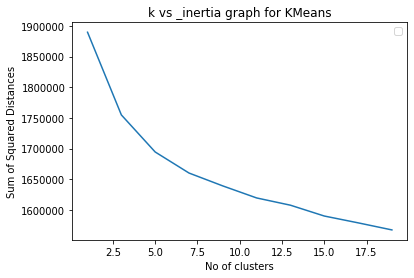

In [69]:
# Please write all the code with proper documentation
search_for_K(bow_vectors.A)

In [387]:
# by looking at the curve we decide optimal value of k=6
labels = label_vectors(bow_vectors.A, 6)

In [388]:
word_counters = get_clusterwise_words(count_vect.get_feature_names(),
                     bow_vectors, labels, 6)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

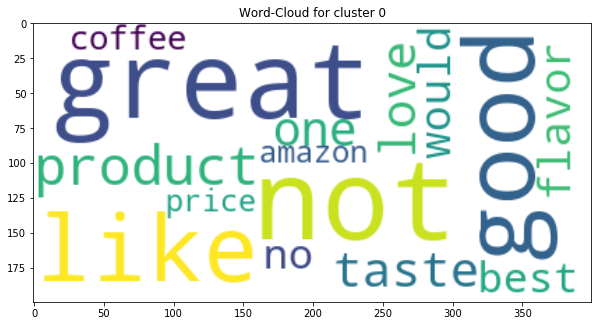

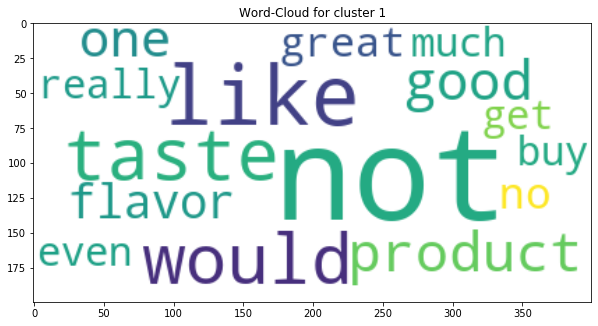

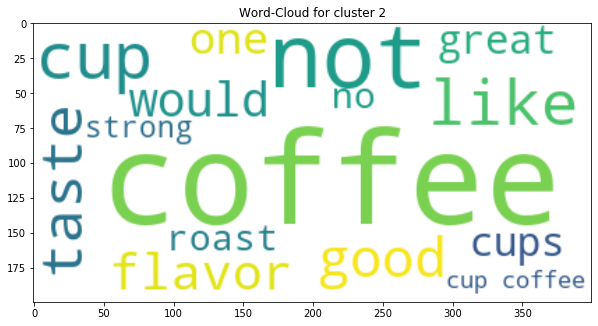

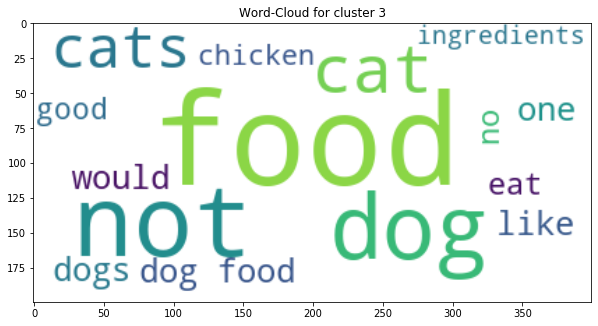

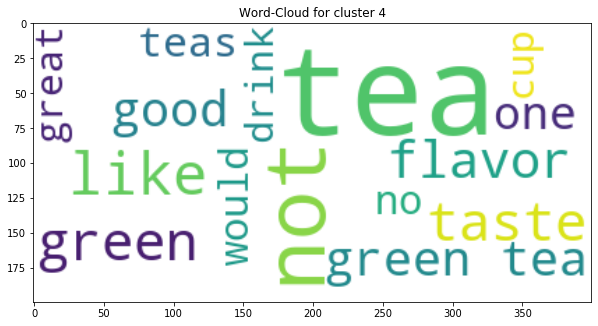

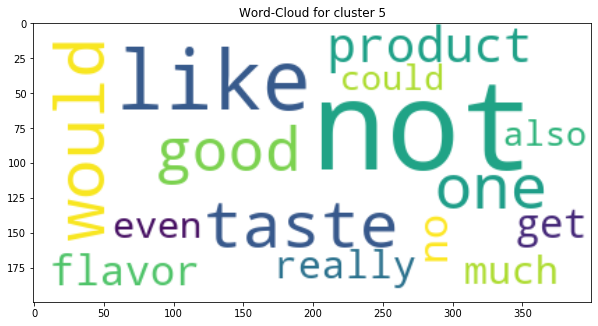

In [390]:
# Please write all the code with proper documentation
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [ ]:
table.add_row(['BOW', 'K-Means','NA',6])

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

No handles with labels found to put in legend.


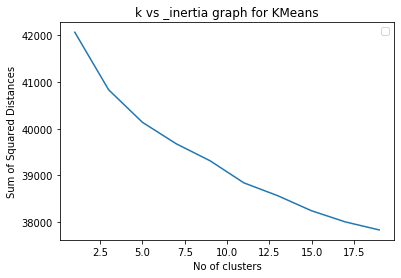

In [349]:
# Please write all the code with proper documentation
search_for_K(tfIdf_vectors.A)

In [350]:
# by looking at the curve we decide optimal value of k=5
labels = label_vectors(tfIdf_vectors.A, 5)

In [378]:
word_counters = get_clusterwise_words(tf_idf_vect.get_feature_names(),
                     tfIdf_vectors, labels, 5)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

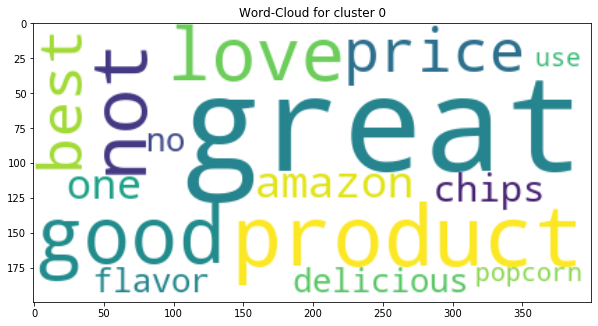

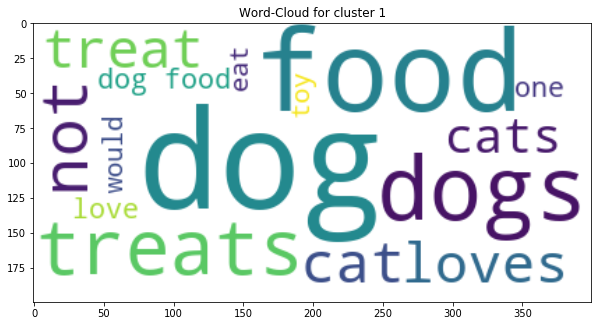

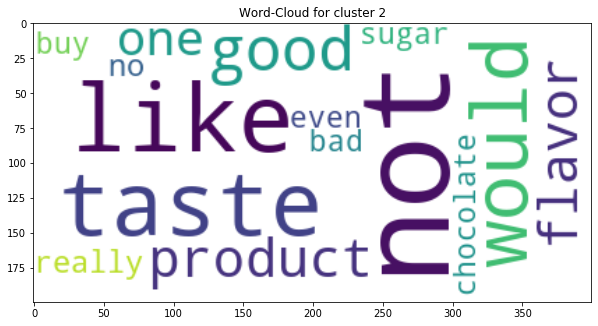

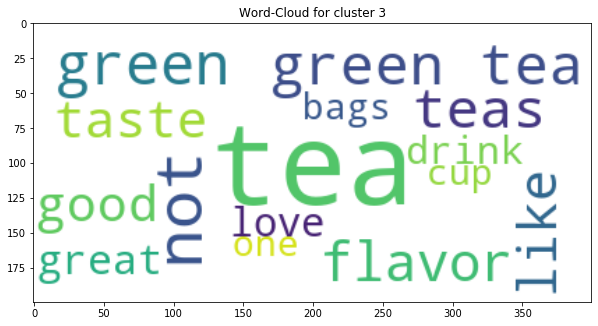

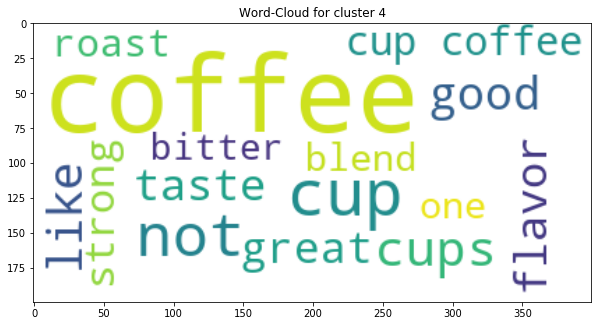

In [386]:
# Please write all the code with proper documentation
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [644]:
table.add_row(['Tf-Idf','K-Means','NA',5])

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

No handles with labels found to put in legend.


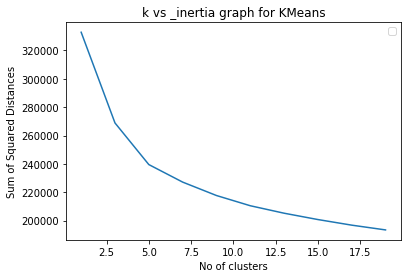

In [398]:
# Please write all the code with proper documentation
search_for_K(avgW2V_vectors)

In [399]:
# by looking at the curve we decide optimal value of k=5
labels = label_vectors(avgW2V_vectors, 5)

In [416]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters = {i:defaultdict(float) for i in range(5)}
for i in range(len(labels)):
    for token in sentence_tokens[i]:
        word_counters[labels[i]][token] += 1

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

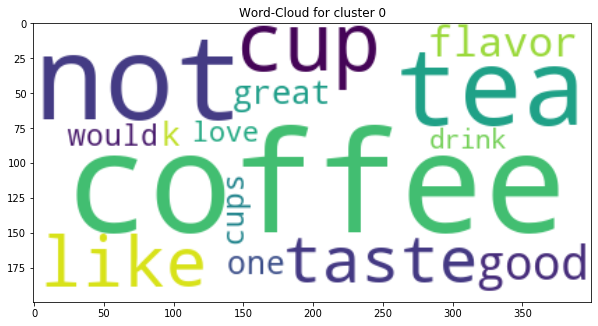

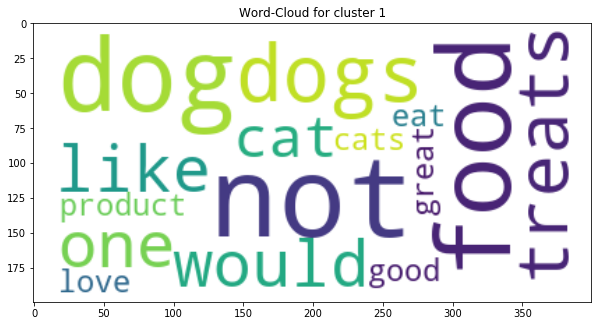

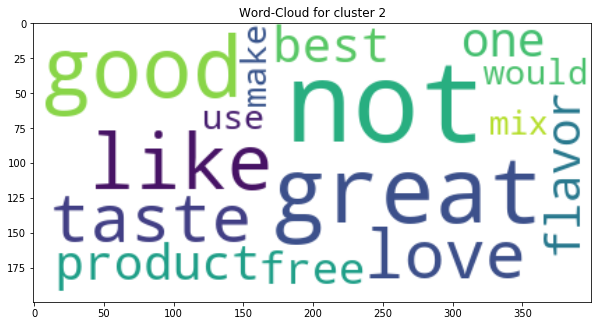

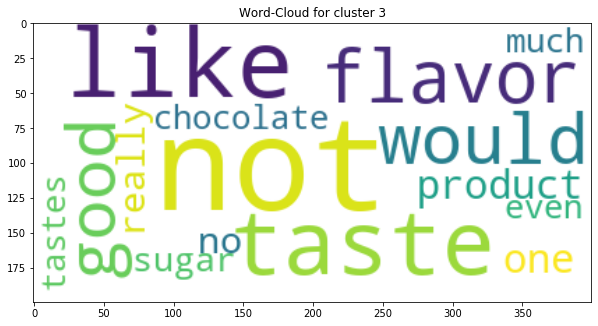

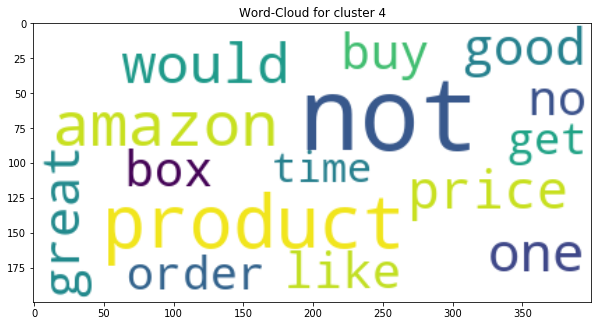

In [417]:
# Please write all the code with proper documentation
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [646]:
table.add_row(['Avg-W2V','K-Means','NA',5])

In [647]:
print(table)

+------------+---------+-----------------+------------+
| Vectorizer |  Model  | Hyperparameters | # Clusters |
+------------+---------+-----------------+------------+
|    BOW     | K-Means |        NA       |     6      |
|   Tf-Idf   | K-Means |        NA       |     5      |
|  Avg-W2V   | K-Means |        NA       |     5      |
+------------+---------+-----------------+------------+


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

No handles with labels found to put in legend.


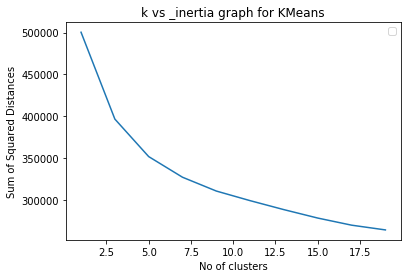

In [418]:
# Please write all the code with proper documentation
search_for_K(tfidf_avgW2V_vectors)

In [420]:
# by looking at the curve we decide optimal value of k=6
labels = label_vectors(tfidf_avgW2V_vectors, 6)

In [421]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters = {i:defaultdict(float) for i in range(6)}
for i in range(len(labels)):
    for token in sentence_tokens[i]:
        word_counters[labels[i]][token] += 1

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

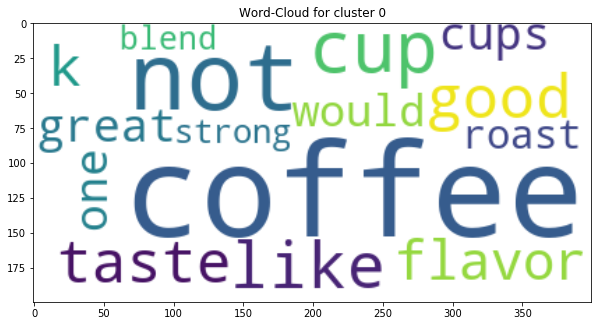

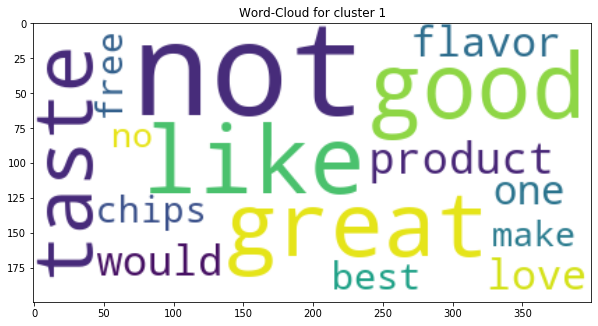

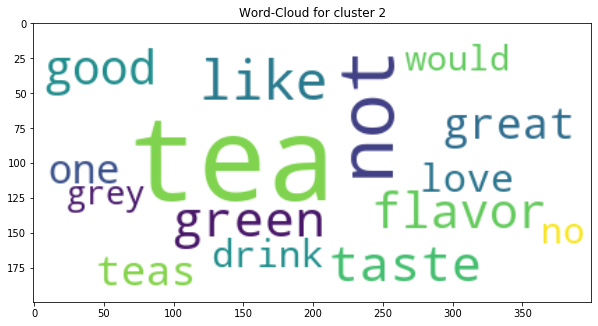

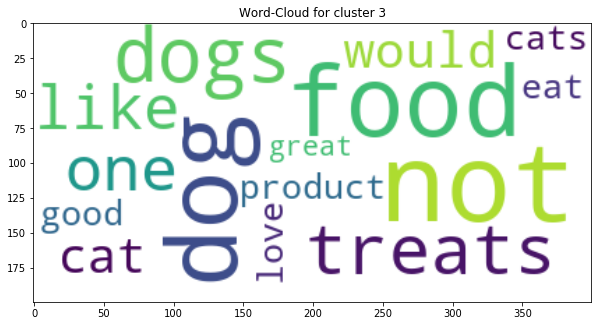

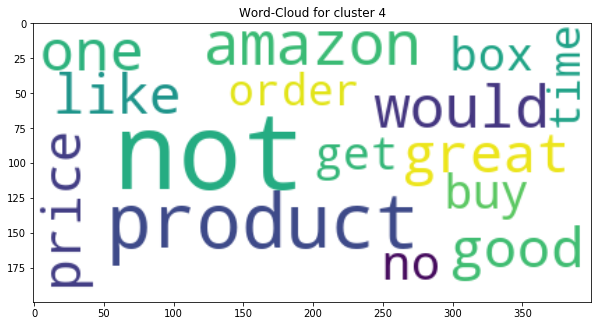

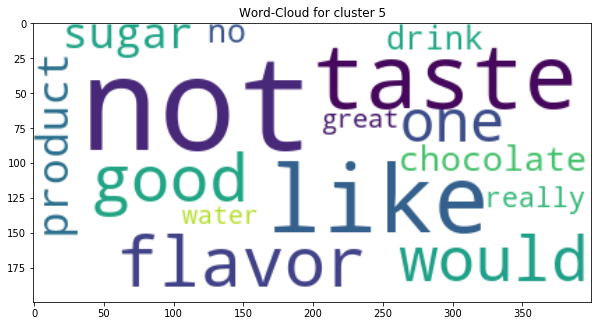

In [422]:
# Please write all the code with proper documentation
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [648]:
table.add_row(['Tf-Idf Avg-W2V','K-Means','NA',6])

In [649]:
print(table)

+----------------+---------+-----------------+------------+
|   Vectorizer   |  Model  | Hyperparameters | # Clusters |
+----------------+---------+-----------------+------------+
|      BOW       | K-Means |        NA       |     6      |
|     Tf-Idf     | K-Means |        NA       |     5      |
|    Avg-W2V     | K-Means |        NA       |     5      |
| Tf-Idf Avg-W2V | K-Means |        NA       |     6      |
+----------------+---------+-----------------+------------+


## [5.2] Agglomerative Clustering

In [508]:
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [485]:
def label_vectors_agg(vectors, num_clusters):
    agg_clust = AgglomerativeClustering(n_clusters=num_clusters,
                               affinity='cosine', linkage='complete')
    labels = agg_clust.fit_predict(vectors)
    return labels

In [455]:
indexes = random.sample(range(0,len(avgW2V_vectors)),10000)

In [507]:
# before agglomerative clustering lets cutdown the vectors to 10k only
avgW2V_vectors_agg = [avgW2V_vectors[i] for i in indexes]
tfidf_avgW2V_vectors_agg = [tfidf_avgW2V_vectors[i] for i in indexes]

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [486]:
# Please write all the code with proper documentation
# we find the clustering labels for 2 values of clustering(2, 5)
labels2 = label_vectors_agg(avgW2V_vectors_agg, 2)

In [487]:
labels5 = label_vectors_agg(avgW2V_vectors_agg,5)

In [491]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters2 = {i:defaultdict(float) for i in range(2)}
for i in range(len(labels2)):
    for token in sentence_tokens[indexes[i]]:
        word_counters2[labels2[i]][token] += 1

In [492]:
word_counters5 = {i:defaultdict(float) for i in range(5)}
for i in range(len(labels5)):
    for token in sentence_tokens[indexes[i]]:
        word_counters5[labels5[i]][token] += 1

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

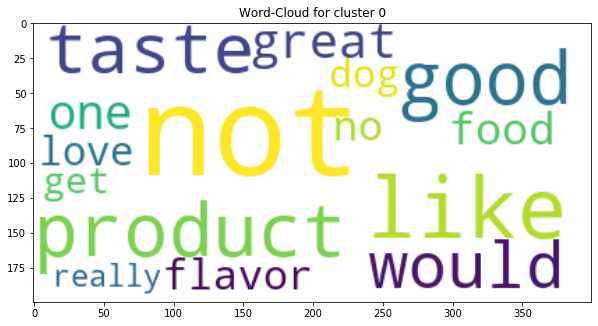

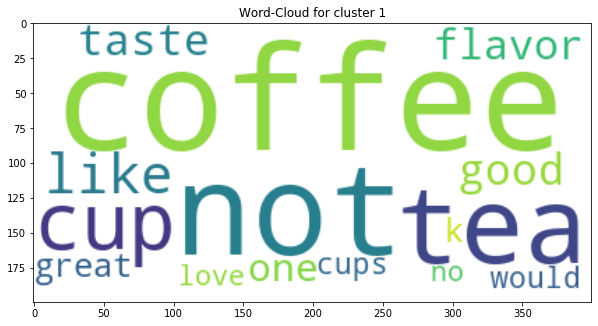

In [493]:
# Please write all the code with proper documentation
# word cloud for 2 clusters 
for c in word_counters2.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters2[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

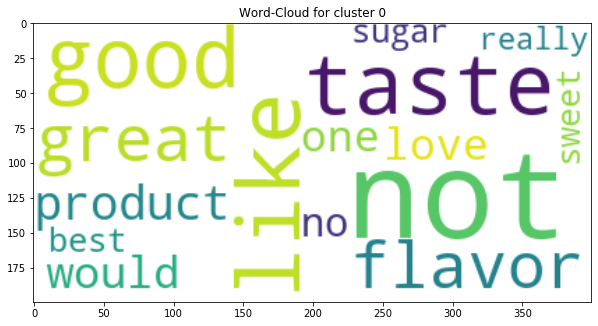

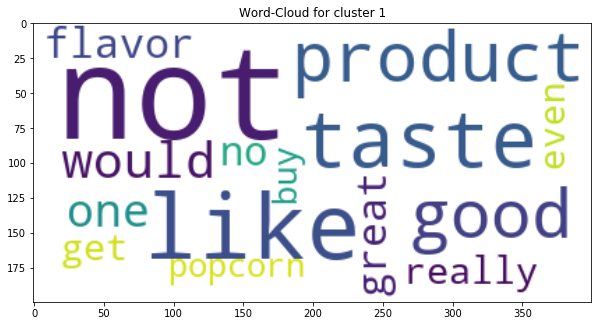

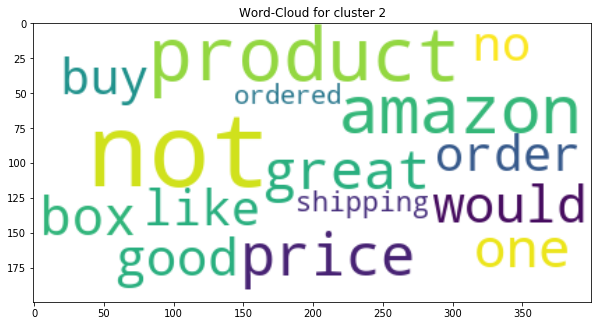

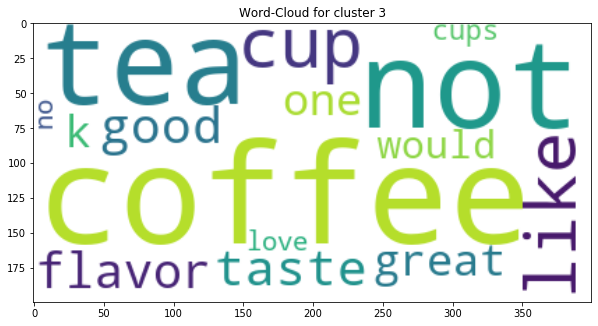

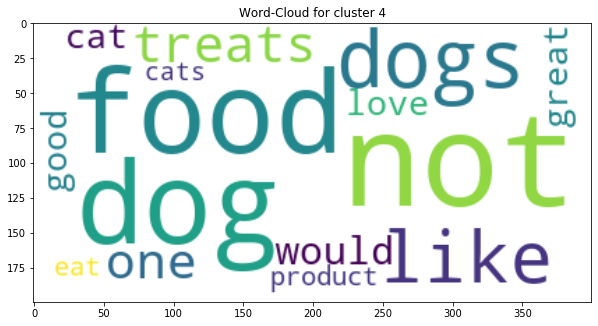

In [494]:
for c in word_counters5.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters5[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [651]:
table.add_row(['Avg-W2V','Agglomerative','NA',[2,5]])

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [495]:
# Please write all the code with proper documentation
# we find the clustering labels for 2 values of clustering(2, 5)
labels2 = label_vectors_agg(tfidf_avgW2V_vectors_agg, 2)

In [496]:
labels5 = label_vectors_agg(tfidf_avgW2V_vectors_agg, 5)

In [497]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters2 = {i:defaultdict(float) for i in range(2)}
for i in range(len(labels2)):
    for token in sentence_tokens[indexes[i]]:
        word_counters2[labels2[i]][token] += 1

In [498]:
word_counters5 = {i:defaultdict(float) for i in range(5)}
for i in range(len(labels5)):
    for token in sentence_tokens[indexes[i]]:
        word_counters5[labels5[i]][token] += 1

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

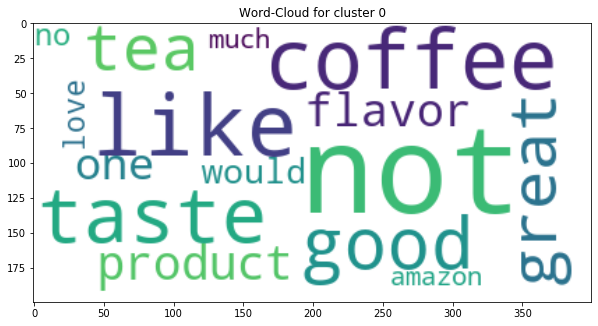

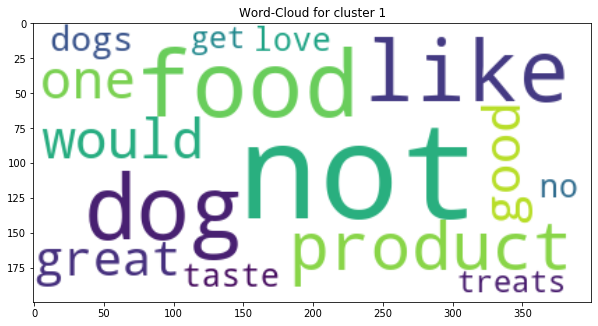

In [499]:
# Please write all the code with proper documentation
for c in word_counters2.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters2[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

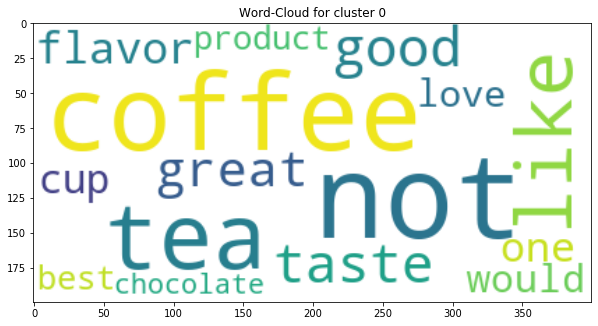

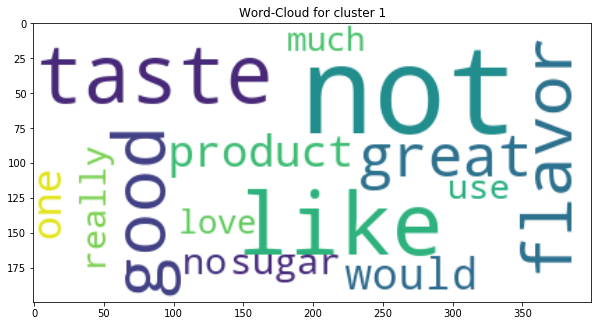

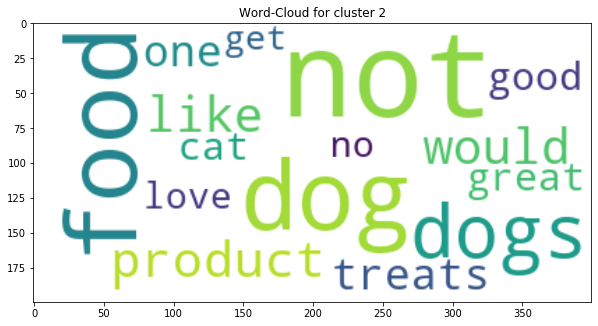

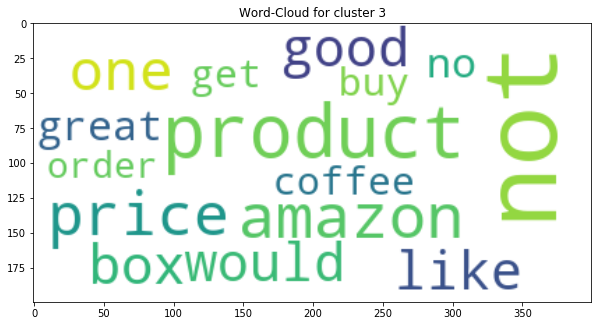

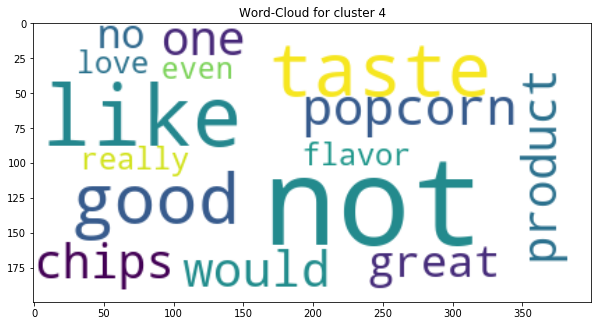

In [500]:
for c in word_counters5.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters5[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [653]:
table.add_row(['Tf-Idf Avg-W2V','Agglomerative','NA',[2,5]])

## [5.3] DBSCAN Clustering

In [567]:
from sklearn.cluster import DBSCAN

In [587]:
avgW2V_vectors_dbS = [avgW2V_vectors[i] for i in indexes]
tfidf_avgW2V_vectors_dbS = [tfidf_avgW2V_vectors[i] for i in indexes]
min_points = len(avgW2V_vectors_agg[1])*2

In [588]:
avgW2V_vectors_dbS = StandardScaler().fit_transform(avgW2V_vectors_dbS)
tfidf_avgW2V_vectors_dbS = StandardScaler().fit_transform(tfidf_avgW2V_vectors_dbS)

In [589]:
# Please write all the code with proper documentation
# claculating distances for each of the xi in the whole dataset
distances = []
for data_point in avgW2V_vectors_dbS:
    # find the distances from data-point to all points
    # and take only the kth point(k = min_point)
    range_dist = np.sort(np.sum((avgW2V_vectors_dbS-data_point)**2, axis=1))
    distances.append(range_dist[min_points])

distances=np.sqrt(np.sort(distances))
point_idx=[i for i in range(len(avgW2V_vectors_dbS))]

No handles with labels found to put in legend.


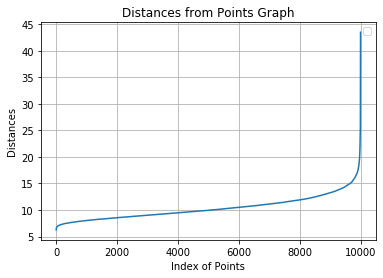

In [618]:
# Draw curve for elbow method
plt.plot(point_idx, distances)
plt.legend()
plt.xlabel("Index of Points")
plt.ylabel("Distances")
plt.grid()
plt.title("Distances from Points Graph")
plt.show()

Observed point of inflexion = 18

In [624]:
eph = 18

In [625]:
def label_vectors_dbS(epsilon, min_points, vectors):
    dbScan = DBSCAN(eps=epsilon, min_samples=min_points, 
                    n_jobs=4)
    labels = dbScan.fit_predict(vectors)
    return labels

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [626]:
labels = label_vectors_dbS(eph, min_points, avgW2V_vectors_dbS)

In [623]:
# NOTE : I am getting only 1 cluster here. Tried with and without Scaling
# and also tried many different values of ephsilon, but everytime I get only
# 1 cluster and the noise points.
print(set(labels))
print(labels.sum())

{0, -1}
-13


In [630]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters = {i:defaultdict(float) for i in range(1)}
for i in range(len(labels)):
    if labels[i] != -1:
        for token in sentence_tokens[indexes[i]]:
            word_counters[labels[i]][token] += 1

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

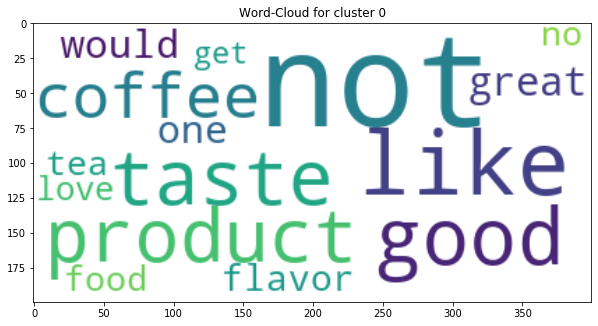

In [633]:
# Please write all the code with proper documentation
# word cloud for 1 cluster 
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [659]:
table.add_row(['Avg-W2V','DBSCAN','Ephsilon=18\nMin_Points=256',1])

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [634]:
# Please write all the code with proper documentation
labels = label_vectors_dbS(eph, min_points, tfidf_avgW2V_vectors_dbS)

In [635]:
print(set(labels))
print(labels.sum())

{0, -1}
-2


In [636]:
# For every datapoint, get the words which were there in the
# corresponding sentence as per which the word2Vec was made
word_counters = {i:defaultdict(float) for i in range(1)}
for i in range(len(labels)):
    if labels[i] != -1:
        for token in sentence_tokens[indexes[i]]:
            word_counters[labels[i]][token] += 1

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

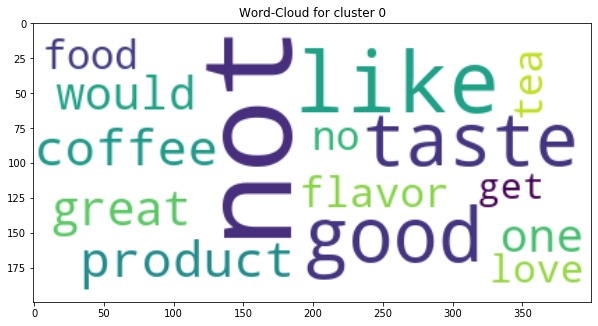

In [637]:
# Please write all the code with proper documentation
# word cloud for 1 cluster 
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

In [660]:
table.add_row(['Tf-Idf Avg-W2V','DBSCAN','Ephsilon=18\nMin_Points=256',1])

# [6] Conclusions

In [665]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
print(table)

+----------------+---------------+-----------------+------------+
|   Vectorizer   |     Model     | Hyperparameters | # Clusters |
+----------------+---------------+-----------------+------------+
|      BOW       |    K-Means    |        NA       |     6      |
|     Tf-Idf     |    K-Means    |        NA       |     5      |
|    Avg-W2V     |    K-Means    |        NA       |     5      |
| Tf-Idf Avg-W2V |    K-Means    |        NA       |     6      |
|    Avg-W2V     | Agglomerative |        NA       |   [2, 5]   |
| Tf-Idf Avg-W2V | Agglomerative |        NA       |   [2, 5]   |
|    Avg-W2V     |     DBSCAN    |   Ephsilon=18   |     1      |
|                |               |  Min_Points=256 |            |
| Tf-Idf Avg-W2V |     DBSCAN    |   Ephsilon=18   |     1      |
|                |               |  Min_Points=256 |            |
+----------------+---------------+-----------------+------------+


    - We can clearly see that number of clusters obtained vary greatly
        depending on the algorithm we are using
    - For BOW, we can see that clusters 0 and 1 are somewhat common in 
        terms of words: 'like', 'would', 'great', 'product'
    - But cluster 2 is more interpretible as it has similar words like :
        'coffee','flavor','good','cups'
    - Also cluster 3 also contains like meaning words : 'cat','dog',
        'dogs','chicken'
    - Similar trend is visible in the clusters obtained using Tf-idf vectors
    - This trend becomes fairly prominent when using average word2Vec vectors. 
        As clusters 0 talks about 'tea','coffee','taste','good', 'cup',
        while cluster 1 is all about 'cats','dogs','food','treats',
        'product','love'.
    - Cluster 2 is about all kinds of adjetives while cluster 3 and 4 
        carry miscellaneous terms 
    - This trend becomes more prominent in the clusters obtained using
        Tf-Idf Avg Vectors
    - For Agglomerative clustering technique using the Avg W2V vectors and 
        2 clusters, we see 1 cluster carrying miscellaneous words and other
        carrying words like 'tea','coffee','cup','taste','flavour'
    - We get some more interpretible grouping while increasing the clusters
        to 5, but we see some words like 'like','not' coming up in multiple
        clusters
    - Same trend is observed while using Tf-Idf Avg W2V vectors and 
        2/5 vectors
    - While using DBSCAN, we find the min_points and ephsilon value to be 
        256 and 18 respectively
    - But in this algorithm, for both the type of vectors we only get 1 
        cluster each apart from the noise points and the words are not 
        very distinctive